# 0. First try


In [1]:
import wandb
from wandb.xgboost import WandbCallback
from xgboost import train, DMatrix, plot_importance, Booster
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import pandas as pd
import numpy as np
# import optuna


In [2]:
!poetry run wandb login


wandb: Currently logged in as: talverinat (loko-bank). Use `wandb login --relogin` to force relogin


In [3]:
import os

os.environ['WANDB_NOTEBOOK_NAME'] = '../notebooks/modeling_xgboost_D24.ipynb'


In [4]:
SEED = 2023
TEST_SIZE = 0.2

NUM_EPOCHES = 5
N_SPLITS = 4
N_REPEATS = 10
N_TRIALS = 200


In [5]:
df = pd.read_parquet("../data/data.parquet")


In [6]:
sz = df.shape


In [7]:
X = df.drop(["date", "D_12", "D_24", "D_36", "D_48", "D"], axis=1)
y = df["D_24"]


In [8]:
X_train_temp, X_test, y_train_temp, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=SEED, shuffle=True, stratify=y
    )


In [9]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_temp, y_train_temp, test_size=TEST_SIZE, random_state=SEED, shuffle=True, stratify=y_train_temp
    )


In [10]:
# Инициализируйте wandb с вашим ключом авторизации
settings = wandb.Settings(job_source="artifact")
wandb.init(project='modeling first run', config={'learning_rate': 0.01, 'max_depth': 3})

# Создайте объект DMatrix для обучающего и тестового набора данных
dtrain = DMatrix(X_train, label=y_train, missing=-1)
dtest = DMatrix(X_valid, label=y_valid, missing=-1)
watchlist = [(dtrain, 'train'), (dtest, 'valid')]

num_boost_round = 100
wandb.config["num_boost_round"] = 100
wandb.config["data_shape"] = sz

# Задайте параметры модели
params = {
    'verbosity': 0,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'validate_parameters': True,
    'enable_categorical': True,
    'learning_rate': wandb.config.learning_rate,
    'max_depth': wandb.config.max_depth
}


wandb: Currently logged in as: talverinat (loko-bank). Use `wandb login --relogin` to force relogin


In [11]:
# Обучите модель
model = train(
    params,
    dtrain,
    evals=watchlist,
    early_stopping_rounds=5,
    num_boost_round=num_boost_round,
    callbacks=[WandbCallback()]
    )


[0]	train-auc:0.75490	valid-auc:0.72043
[1]	train-auc:0.75490	valid-auc:0.72043
[2]	train-auc:0.75490	valid-auc:0.72043
[3]	train-auc:0.75490	valid-auc:0.72043
[4]	train-auc:0.75490	valid-auc:0.72043


In [12]:
# Сделайте предсказания
y_pred = model.predict(dtest)

# Оцените точность модели
gini_score = 2 * roc_auc_score(y_valid, y_pred) - 1

# Залогируйте метрики
wandb.log({'gini': gini_score})


In [ ]:
import pickle

# save the iris classification model as a pickle file
model_pkl_file = "../models/xgboost_D24.pkl"  

with open(model_pkl_file, 'wb') as file:  
    pickle.dump(model, file)


# 1. Features importance


## 1.1 Широта деревьев (Tree SHAP)


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


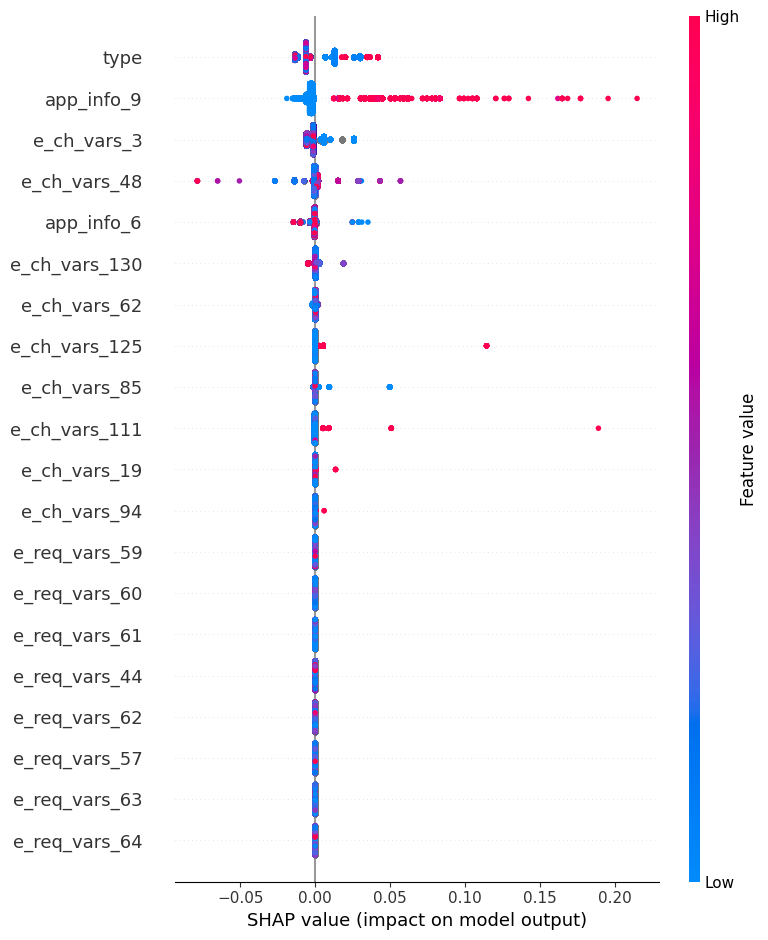

In [13]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap_plot = shap.summary_plot(shap_values, X_test)
wandb.log({"shap_summary_plot": shap_plot})
shap_plot


## 1.2 RFE

Рекурссивное удаление наименее важных фич, обучая модель на уменьшающемся наборе фич


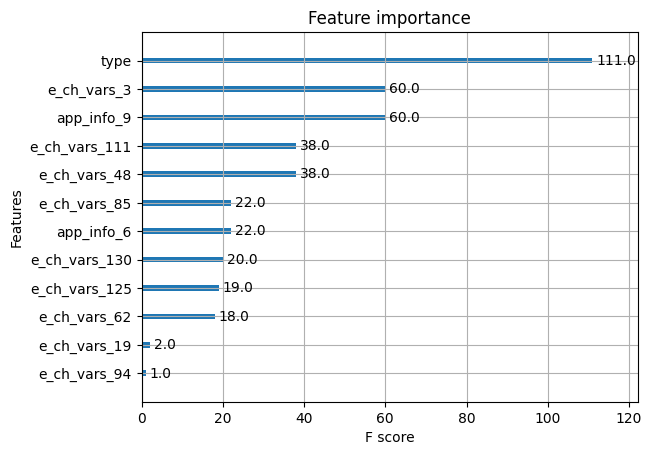

In [15]:

plt = plot_importance(model)
wandb.log({"xgboost_feat_importance": wandb.Image(plt)})


# 2. Optuna, hyperparams search


In [ ]:
def get_result(X, y params):
    iteration = 0
    result = []
    for epoche in range(NUM_EPOCHES):
        cv = RepeatedKFold(
            n_splits=N_SPLITS,
            n_repeats=N_REPEATS,
            random_state=epoche
        )
        eval_res = []
        for x in cv.split(X):
            x_train = DMatrix(
                X.iloc[x[0]],
                y.iloc[x[0]],
                missing=-1
            )
            x_valid = DMatrix(
                X.iloc[[1]],
                y.iloc[[1]],
                missing=-1
            )
            watchlist = [(x_train, 'train'), (x_valid, 'valid')]
            evals_result = {}
            booster: Booster = train(
                params=params,
                num_boostround=1,
                dtrain=x_train,
                evals=watchlist,
                early_stopping_round=5,
                verbose_eval=0,
                evals_result=evals_result,
                callbacks=[WandbCallback()]
            )
        
            eval_res.append(evals_result['valid']['auc'])
            iteration += 1
        l_ap = list(np.reshape(eval_res, -1))
        result.append(np.mean(l_ap))
    return np.mean(result)



In [ ]:
def objective(trial, X, y):
    # Используйте Optuna для оптимизации параметров
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'seed': SEED,
        'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart']),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1.0),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'eta': trial.suggest_float('eta', 0.0, 0.5),
        'max_delta_step': trial.suggest_int('max_delta_step', 1, 10),
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True)
    }

    return get_result(X, y, params)


In [ ]:
# Инициализируйте Optuna
study = optuna.create_study(direction='maximize')
study.optimize(
    lambda trial: objective(trial, dtrain, dtest ), n_trials=N_TRIALS)

# Выведите наилучшие параметры
print('Best trial:')
trial = study.best_trial

print(f'Gini Score: {trial.value:.4f}')
print(f'Best Parameters: {trial.params}')


In [ ]:
# Закончите сессию wandb
# wandb.finish()
